In [1]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel
# import the LightModel class #
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

!dir

 El volumen de la unidad C no tiene etiqueta.
 El n£mero de serie del volumen es: 3288-2E83

 Directorio de C:\Users\Aristizabal.juan\OneDrive - Universidad de Los Andes\H0LICOW\Lenstronomy\Simulaciones\Data R0

10/09/2019  17:25    <DIR>          .
10/09/2019  17:25    <DIR>          ..
10/09/2019  07:31    <DIR>          .ipynb_checkpoints
09/09/2019  08:59    <DIR>          drizzled_image
08/09/2019  10:15          (15.748) Image.png
28/07/2019  17:54            43.200 lens-image.fits
28/12/2017  06:25            43.200 noise_map.fits
28/08/2019  15:14           259.200 oversampled_PSF.fits
28/12/2017  06:25            43.200 psf.fits
30/08/2019  16:26            49.358 Rung000.ipynb
08/09/2019  10:20            64.165 Rung001.ipynb
08/09/2019  10:17          (25.064) Rung002.ipynb
10/09/2019  17:25            14.390 Rung003.ipynb
               9 archivos        557.525 bytes
               4 dirs  118.025.441.280 bytes libres


In [2]:
# Manejo de los  FITS mendiante el HEADER.
import astropy
import numpy as np
from astropy.utils.data import download_file
from astropy.io import fits


fits_image_filename = fits.util.get_testdata_filepath('lens-image.fits')
#fits_image_filename = fits.util.get_testdata_filepath('lens-image.fits')
hdul = fits.open('lens-image.fits')
hdul.info()
image_data = hdul[0].data

with fits.open(fits_image_filename) as hdul:
    data = hdul[0].data
    
print(data[30:35,10:15])
data[1,1]
data[0:99,0:99]
print(type(image_data))
print(image_data.shape)

#with fits.open 

hdul.info()

header = hdul['PRIMARY'].header

header

Filename: lens-image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (99, 99)   float32   
[[0.03136386 0.03500059 0.03739268 0.03882194 0.04340159]
 [0.03046334 0.03410725 0.03714456 0.03844928 0.04408636]
 [0.03098063 0.0345967  0.03800554 0.04178886 0.04544994]
 [0.03020139 0.03780861 0.04213228 0.04424988 0.04620156]
 [0.0338771  0.03702175 0.04317106 0.0456653  0.04928451]]
<class 'numpy.ndarray'>
(99, 99)
Filename: C:\ProgramData\Anaconda3\lib\site-packages\astropy\io\fits\tests\data\lens-image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (99, 99)   float32   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   99                                                  
NAXIS2  =                   99                                                  
EXTEND  =                    T                                                  

In [3]:
# Datos observacionales basicos, se recomienda usar los del Hubble 
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 99  # cutout pixel size
deltaPix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

#Especificaciones del PSF
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

In [4]:
import lenstronomy.Util.param_util as param_util
#DATOS RUNG-0

#### LENTE SPEMD #####
q = 0.787
phi=1.605
#Transformacion
e1, e2 = param_util.phi_q2_ellipticity(phi=phi, q=q)

#### LENTE LIGHT #####
ql=0.969
phil=1.731
#Transformacion
el1, el2 = param_util.phi_q2_ellipticity(phi=phil, q=ql)

#### SOURCE LIGHT ####
qs = 0.853
phis = 2.805
#Transformacion
es1, es2 = param_util.phi_q2_ellipticity(phi=phis, q=qs)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log10


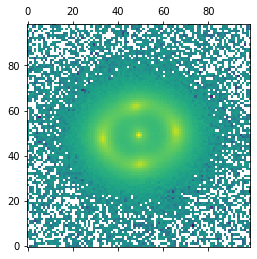

In [5]:
###### LENTE ########

#Modelos de masa y luz para la lente
lens_model_list = ['SPEP', 'SHEAR']
lens_light_model_list = ['SERSIC_ELLIPSE']

#Modelos de luz de la fuente y el lente
#lightModel_source = LightModel(light_model_list=source_light_model_list)
#lightModel_lens = LightModel(light_model_list=lens_light_model_list)

lensModel = LensModel(lens_model_list=lens_model_list)

#Modelos de distribucion de masa del lente
#kwargs_shear = {'gamma_ext': 0.01, 'psi_ext': -0.1} #parametros sin fundamento
kwargs_shear = {'e1': 0.007, 'e2': 0.027} # de acuerdo al Rung0
kwargs_spemd = {'theta_E':1.161,'gamma':2.044,'center_x':0,'center_y':0,'e1':e1,'e2':e2}
#kwargs_sis = {'theta_E': 0.1, 'center_x': 1., 'center_y': -0.1}

kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

#Definiendo modelos de luz SERSIC del lente
kwargs_sersic_ellipse = {'amp': 400, 'R_sersic': 0.991, 'n_sersic': 3.786, 'center_x': 0, 
                         'center_y': 0,'e1':el1,'e2':el2}
kwargs_lens_light = [kwargs_sersic_ellipse]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)



###### FUENTE #######

source_model_list = ['SERSIC_ELLIPSE']

# Modelos de luz para la fuente
ra_source, dec_source = 0.02, 0.001
kwargs_sersic_ellipse = {'amp':4000,'R_sersic':0.338,'n_sersic':2.582,'center_x':ra_source, 
                         'center_y':dec_source, 'e1':es1, 'e2':es2} 
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)


##### SOLUCION DE LENTE ########
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*100}]  
# quasar point source position in the source plane and intrinsic brightness

point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()


In [6]:
#### Modelado Lente #######

# image plane coordinate # Datos inicialmente truncados
theta_ra, theta_dec = 0.9, 0.4

# source plane coordinate #
beta_ra, beta_dec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)
# Fermat potential #
fermat_pot = lensModel.fermat_potential(x_image=theta_ra, y_image=theta_dec, x_source=beta_ra, y_source=beta_dec, kwargs_lens=kwargs_lens)

# Magnification #

mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

In [7]:
### LENTE MULTIPLANO #####
# keep the imports and variables from above #
# specify redshifts of deflectors #
redshift_list = [0.858, 0.858]
#z_lens = 0.858
# specify source redshift #
z_source = 2.175
# setup lens model class with the list of lens models #
lensModel_mp = LensModel(lens_model_list=lens_model_list, z_source=z_source, lens_redshift_list=redshift_list, multi_plane=True)

# source plane coordinate #
beta_ra, beta_dec = lensModel_mp.ray_shooting(theta_ra, theta_dec, kwargs_lens)

# Magnification #
mag = lensModel_mp.magnification(theta_ra, theta_dec, kwargs_lens)

# arrival time relative to a straight path through (0,0) #
dt = lensModel_mp.arrival_time(theta_ra, theta_dec, kwargs_lens)

In [8]:
# keep the imports and variables from above #
# import the lens equation solver class #
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

# the magnification of the point source images #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


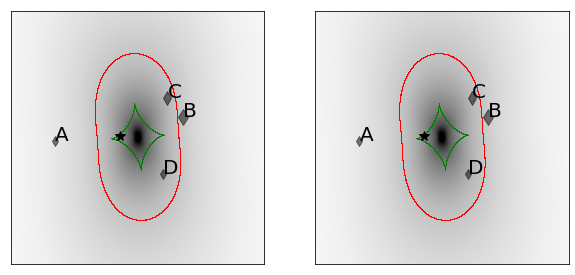

In [9]:
import lenstronomy.Plots.output_plots as lens_plot
f, axex = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex[0], lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True)
lens_plot.lens_model_plot(axex[1], lensModel=lensModel_mp, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True)
f.show()

In [32]:
####### DESCOMPOSICION HOST DEL QUASAR.

# import of standard python libraries
import numpy as np
import os
import time
import copy
import corner
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

!DIR

# Manejo de los  FITS mendiante el HEADER.
import astropy
import numpy as np
from astropy.utils.data import download_file
from astropy.io import fits


fits_image_filename = fits.util.get_testdata_filepath('psf.fits')
#fits_image_filename = fits.util.get_testdata_filepath('lens-image.fits')
hdul = fits.open('psf.fits')
hdul.info()
image_data = hdul[0].data

with fits.open(fits_image_filename) as hdul:
    data = hdul[0].data
    
#print(data[30:35,10:15])
data[1,1]
data[0:99,0:99]
print(type(image_data))
print(image_data.shape)

#with fits.open 

hdul.info()

header = hdul['PRIMARY'].header

header

 El volumen de la unidad C no tiene etiqueta.
 El n£mero de serie del volumen es: 3288-2E83

 Directorio de C:\Users\Aristizabal.juan\OneDrive - Universidad de Los Andes\H0LICOW\Lenstronomy\Simulaciones\Data R0

10/09/2019  18:09    <DIR>          .
10/09/2019  18:09    <DIR>          ..
10/09/2019  07:31    <DIR>          .ipynb_checkpoints
09/09/2019  08:59    <DIR>          drizzled_image
08/09/2019  10:15          (15.748) Image.png
28/07/2019  17:54            43.200 lens-image.fits
28/12/2017  06:25            43.200 noise_map.fits
28/08/2019  15:14           259.200 oversampled_PSF.fits
28/12/2017  06:25            43.200 psf.fits
30/08/2019  16:26            49.358 Rung000.ipynb
08/09/2019  10:20            64.165 Rung001.ipynb
08/09/2019  10:17            25.064 Rung002.ipynb
10/09/2019  18:09         1.065.527 Rung003.ipynb
               9 archivos      1.608.662 bytes
               4 dirs  118.019.817.472 bytes libres
Filename: psf.fits
No.    Name      Ver    Type      Ca

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   99                                                  
NAXIS2  =                   99                                                  
EXTEND  =                    T                                                  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


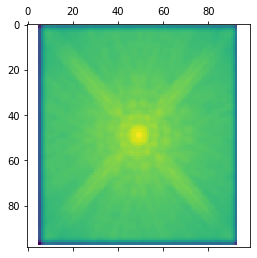

In [33]:
# import main simulation class of lenstronomy
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util

# import PSF file (here as a relative path in the lenstronomy_extension repository)
# the psf_example.fits file can be found here:
# https://github.com/sibirrer/lenstronomy_extensions/tree/master/Data/PSF_TinyTim
# and imported from a local file path as well
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Simulaciones/Data R0/psf.fits')
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()


# data specifics
background_rms = 0.12  #  background noise per pixel (Gaussian)
exp_time = 99.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 99  #  cutout pixel size
deltaPix = 0.08  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'kernel_point_source': kernel_cut, 'pixel_size': deltaPix}
psf_class = PSF(**kwargs_psf)


In [42]:
# quasar center (we chose a off-centered position)
center_x = 0.02
center_y = 0.001

# quasar brightness (as measured as the sum of pixel values)
point_amp = 10000 
from lenstronomy.PointSource.point_source import PointSource
point_source_list = ['UNLENSED']
pointSource = PointSource(point_source_type_list=point_source_list)
kwargs_ps = [{'ra_image': [center_x], 'dec_image': [center_y], 'point_amp': [point_amp]}]

from lenstronomy.LightModel.light_model import LightModel
light_model_list = ['SERSIC_ELLIPSE', 'SERSIC']
lightModel = LightModel(light_model_list=light_model_list)
import lenstronomy.Util.param_util as param_util
e1, e2 = param_util.phi_q2_ellipticity(phi=1.731, q=0.969)
kwargs_disk = {'amp': 400, 'n_sersic': 3.786, 'R_sersic': 0.969, 'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y}
kwargs_buldge = {'amp': 400, 'n_sersic': 5, 'R_sersic': 0.9, 'center_x': center_x, 'center_y': center_y}
kwargs_host = [kwargs_disk, kwargs_buldge]

print(e1)


-0.014942774634311954


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


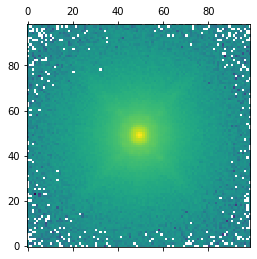

In [35]:
from lenstronomy.ImSim.image_model import ImageModel

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel,
                                point_source_class=pointSource, kwargs_numerics=kwargs_numerics)

# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens_light=kwargs_host, kwargs_ps=kwargs_ps)

# we can also add noise #
import lenstronomy.Util.image_util as image_util
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson
plt.matshow(np.log10(image_noisy), origin='lower')
plt.show()
kwargs_data['image_data'] = image_noisy
data_class.update_data(image_noisy)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


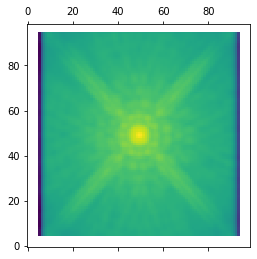

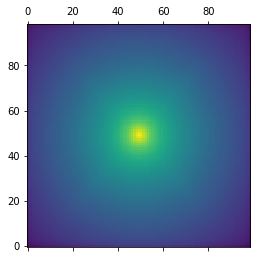

In [37]:
# we can also simulate the different components separately
imageModel_ps = ImageModel(data_class, psf_class, point_source_class=pointSource, kwargs_numerics=kwargs_numerics)
image_ps = imageModel_ps.image(kwargs_ps=kwargs_ps)
plt.matshow(np.log10(image_ps), origin='lower')
plt.show()

imageModel_host = ImageModel(data_class, psf_class, lens_light_model_class=lightModel, kwargs_numerics=kwargs_numerics)
image_host = imageModel_host.image(kwargs_lens_light=kwargs_host)
plt.matshow(np.log10(image_host), origin='lower')
plt.show()

In [38]:
# here are the options for the host galaxy fitting
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# Disk component, as modelled by an elliptical Sersic profile
fixed_source.append({'n_sersic': 1})  # we fix the Sersic index to n=1 (exponential)
kwargs_source_init.append({'R_sersic': 1., 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.5, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

# Buldge component, as modelled by a spherical Sersic profile
fixed_source.append({'n_sersic': 4})  # we fix the Sersic index to n=4 (buldgy)
kwargs_source_init.append({'R_sersic': .5, 'n_sersic': 4, 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.3, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': [0.01], 'dec_image': [0.01]}]
kwargs_lower_ps = [{'ra_image': [-10], 'dec_image': [-10]}]
kwargs_upper_ps = [{'ra_image': [10], 'dec_image': [10]}]

ps_param = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_light_model': source_params,
               'point_source_model': ps_param}

In [39]:
kwargs_model = { 'lens_light_model_list': light_model_list,
                'point_source_model_list': point_source_list
                 }

# numerical options and fitting sequences

kwargs_constraints = {'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']]],
                      'joint_lens_light_with_point_source': [[0, 0], [0, 1]],
                      #'fix_to_point_source_list': [True, True],  # this results in a shared center of the host galaxy with the point source (quasar)
                      'num_point_source_list': [1]
                     }

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,
                             }
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],
                       ['MCMC', {'n_burn': 100, 'n_run': 100, 'walkerRatio': 10,'sigma_scale': .1}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...
10
20
30
40
50
60
70
80
90
converged after 90 iterations!
best fit found:  -4797.556894982926 [1.17094046e+00 1.29535172e-01 2.07706394e-02 9.49123297e-01
 2.00399525e-02 1.02168984e-03]
-0.9798931566550093 reduced X^2 of best position
-4797.556894982926 logL
9792.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.1709404562576975, 'n_sersic': 1, 'e1': 0.12953517190987682, 'e2': 0.02077063941976827, 'center_x': 0.02003995247740093, 'center_y': 0.001021689840089242}, {'amp': 1, 'R_sersic': 0.9491232974027984, 'n_sersic': 4, 'center_x': 0.02003995247740093, 'center_y': 0.001021689840089242}] lens light result
[{'ra_image': array([0.02003995]), 'dec_image': array([0.00102169]), 'point_amp': 1}] point source result
{} special param result
70.54254913330078 time used for PSO PSO
Computing the MCMC...
Number of walkers =  60
Burn-in iterations:  100
Sampling iterations: 100
InMemoryStorageUtil does not support storeRandomState
10

reduced chi^2 =  0.9866883156302662


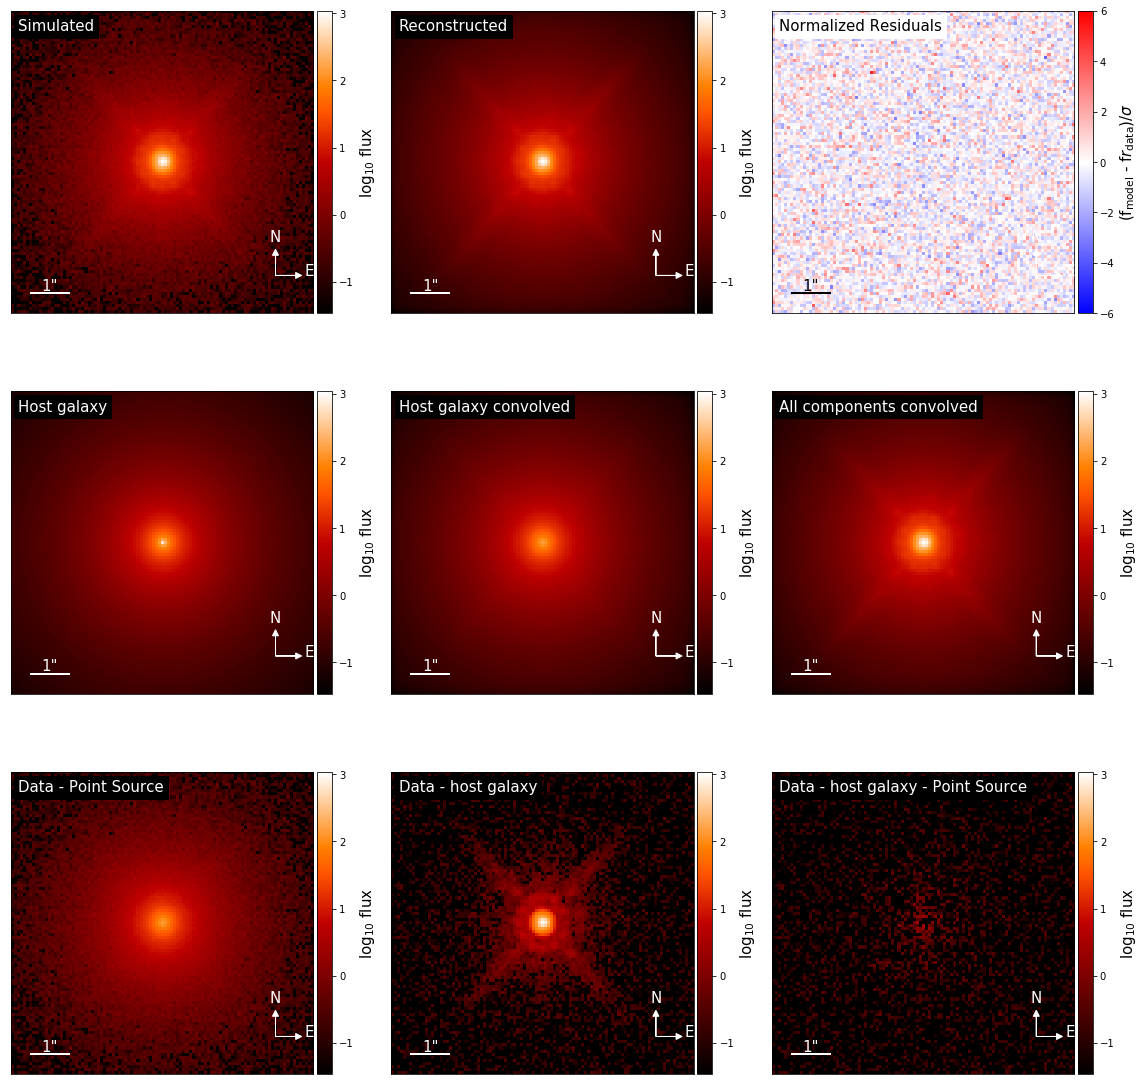

In [40]:
# let's plot the output of the PSO minimizer
from lenstronomy.Plots.output_plots import ModelPlot
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(3, 3, figsize=(16, 16), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0], text="Simulated")
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)

modelPlot.decomposition_plot(ax=axes[1,0], text='Host galaxy', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Host galaxy convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)

modelPlot.subtract_from_data_plot(ax=axes[2,0], text='Data - Point Source', point_source_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2,1], text='Data - host galaxy', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2,2], text='Data - host galaxy - Point Source', lens_light_add=True, point_source_add=True)

f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


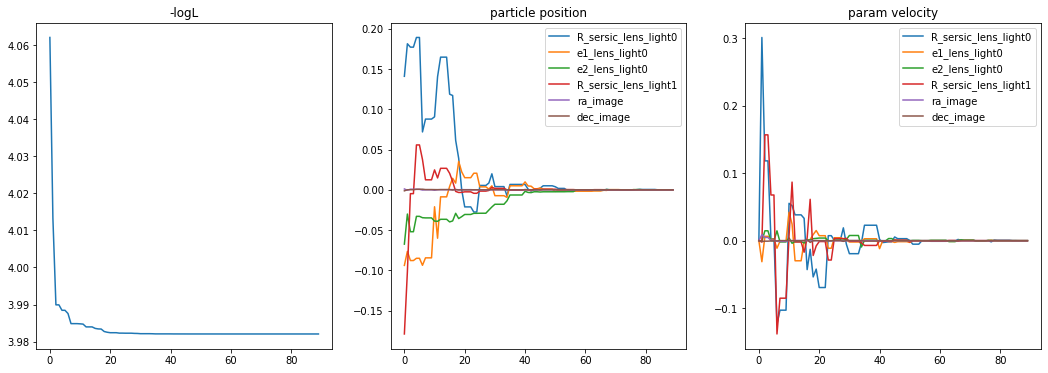

<Figure size 432x288 with 0 Axes>

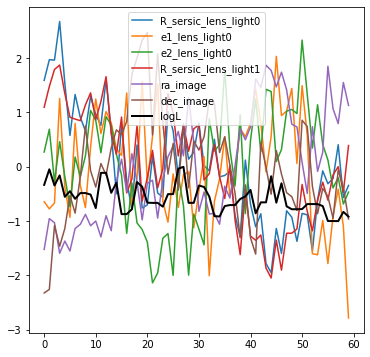

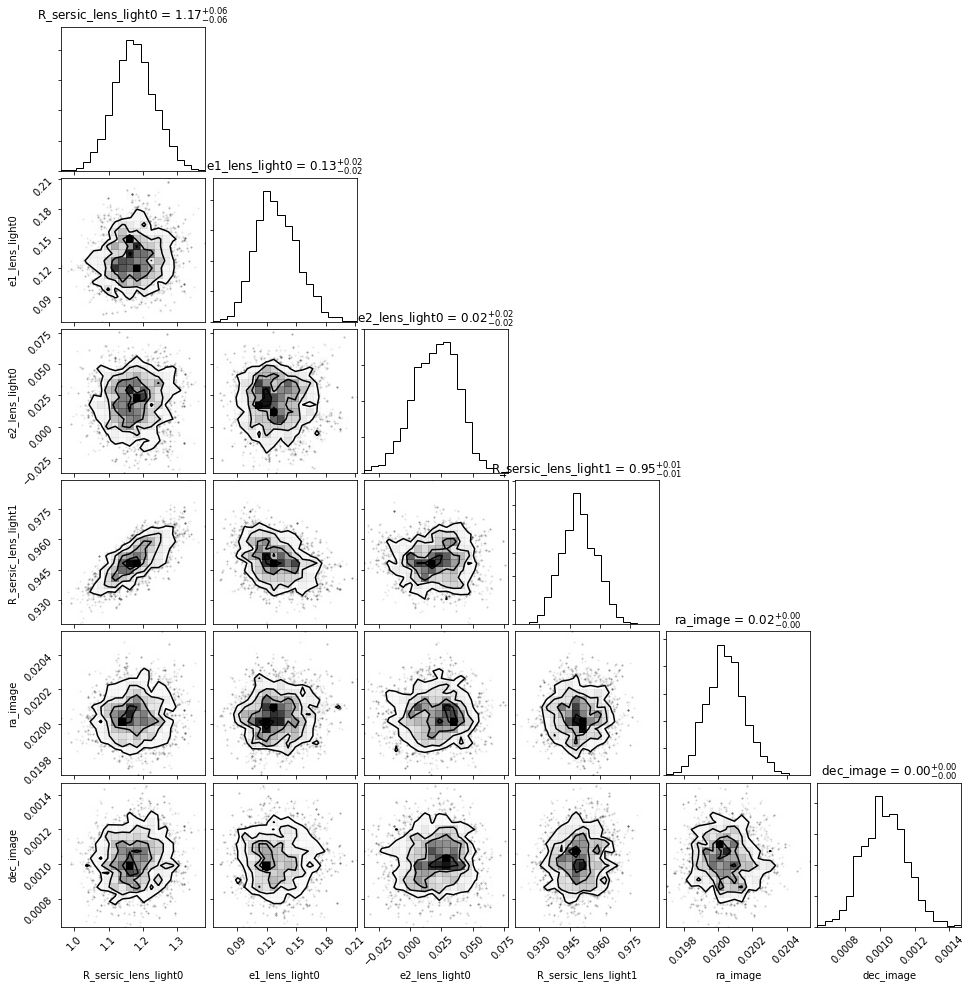

In [41]:
import lenstronomy.Plots.output_plots as out_plot

# here the (non-converged) MCMC chain of the non-linear parameters
for i in range(len(chain_list)):
    out_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

import corner
if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc, labels=param_mcmc, show_titles=True)